In [1]:
# Step 1: Install gdown
!pip install -q gdown

# Step 2: Download the ZIP file from your Google Drive link
!gdown --id 1GsnkaeJkd7Fx3mwuVcN3vhvLscbVW3rg -O Main.zip

# Step 3: Unzip into /content/dataset
!unzip -q Main.zip -d /content/dataset

# Step 4: List extracted folders to verify
!ls /content/dataset

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1GsnkaeJkd7Fx3mwuVcN3vhvLscbVW3rg
From (redirected): https://drive.google.com/uc?id=1GsnkaeJkd7Fx3mwuVcN3vhvLscbVW3rg&confirm=t&uuid=243a8d76-ff6a-41e2-9d83-d65551cd8952
To: /content/Main.zip
100% 5.10G/5.10G [00:45<00:00, 111MB/s]
Main


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

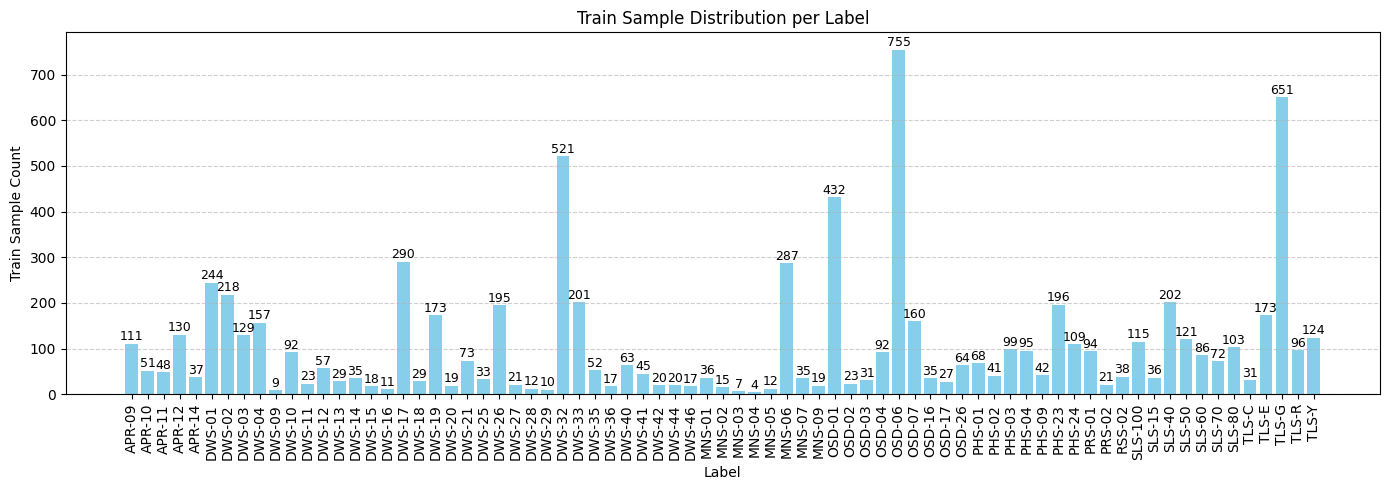

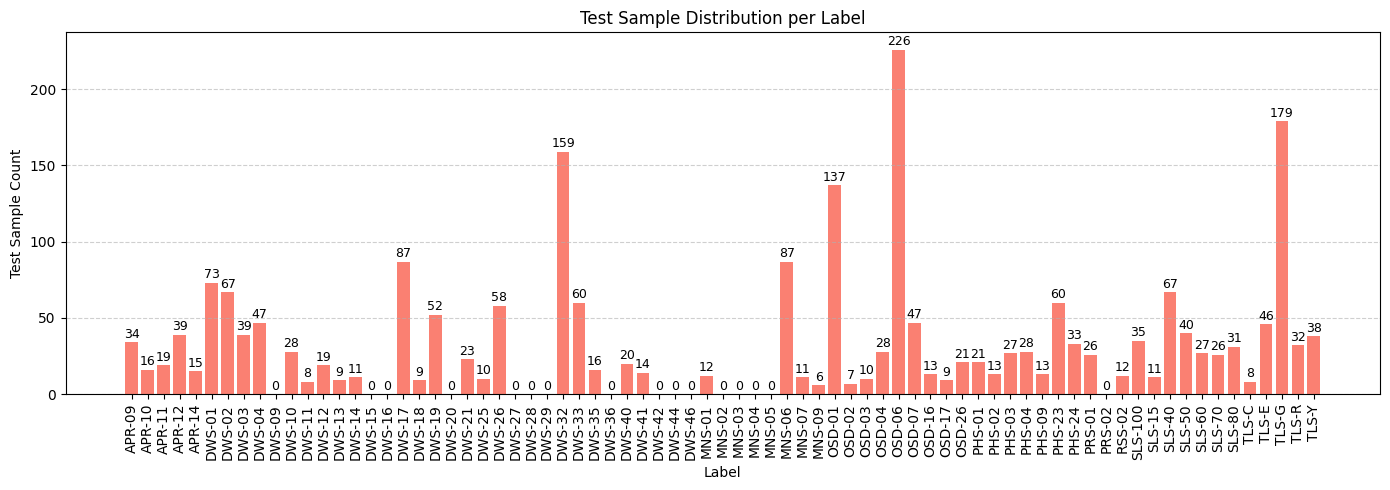

In [3]:
# Load and clean the data
df = pd.read_csv('/content/dataset/Main/label_frequencies.xlsx - Label Frequencies.csv')
df = df.drop(columns=['Total'])
df = df[df['Label'].str.lower() != 'total']

# --- Plot Train Distribution ---
plt.figure(figsize=(14, 5))
bars = plt.bar(df['Label'], df['Train'], color='skyblue')
plt.title('Train Sample Distribution per Label')
plt.xlabel('Label')
plt.ylabel('Train Sample Count')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels on top
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(height), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# --- Plot Test Distribution ---
plt.figure(figsize=(14, 5))
bars = plt.bar(df['Label'], df['Test'], color='salmon')
plt.title('Test Sample Distribution per Label')
plt.xlabel('Label')
plt.ylabel('Test Sample Count')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels on top
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(height), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [4]:
!ls /content/dataset/Main

'label_frequencies.xlsx - Label Frequencies.csv'   sample   test   train


In [5]:
import os
import shutil
import xml.etree.ElementTree as ET
import pandas as pd

# Define base dataset directory
base_dir = './dataset/Main'

# Create destination structure
splits = ['train', 'val', 'test']
for split in splits:
    os.makedirs(f'./final_dataset/{split}/images', exist_ok=True)
    os.makedirs(f'./final_dataset/{split}/labels', exist_ok=True)

# Read class labels from Excel
df = pd.read_csv('/content/dataset/Main/label_frequencies.xlsx - Label Frequencies.csv')
df = df.drop(columns=['Total'], errors='ignore')
df = df[df['Label'].str.lower() != 'total']
class_list = df['Label'].tolist()

# XML to YOLO format conversion
def convert_and_move(source_dir, img_files, target_split):
    for file in img_files:
        img_path = os.path.join(source_dir, file)
        xml_path = os.path.join(source_dir, file.replace('.jpg', '.xml'))

        if not os.path.exists(xml_path):
            continue

        # Copy image
        shutil.copy(img_path, f'./final_dataset/{target_split}/images/{file}')

        # Convert XML to YOLO
        tree = ET.parse(xml_path)
        root = tree.getroot()
        width = int(root.find("size/width").text)
        height = int(root.find("size/height").text)

        with open(f'./final_dataset/{target_split}/labels/{file.replace(".jpg", ".txt")}', "w") as f:
            for obj in root.findall("object"):
                class_name = obj.find("name").text
                if class_name not in class_list:
                    continue
                class_id = class_list.index(class_name)

                bbox = obj.find("bndbox")
                xmin = int(bbox.find("xmin").text)
                ymin = int(bbox.find("ymin").text)
                xmax = int(bbox.find("xmax").text)
                ymax = int(bbox.find("ymax").text)

                cx = ((xmin + xmax) / 2) / width
                cy = ((ymin + ymax) / 2) / height
                w = (xmax - xmin) / width
                h = (ymax - ymin) / height

                f.write(f"{class_id} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}\n")

# Process train set
train_dir = os.path.join(base_dir, 'train')
train_images = [f for f in os.listdir(train_dir) if f.endswith('.jpg')]
convert_and_move(train_dir, train_images, 'train')

# Split test into test and val (50/50)
test_dir = os.path.join(base_dir, 'test')
test_images = [f for f in os.listdir(test_dir) if f.endswith('.jpg')]
mid = len(test_images) // 2
val_images = test_images[:mid]
test_images = test_images[mid:]

convert_and_move(test_dir, val_images, 'val')
convert_and_move(test_dir, test_images, 'test')

<Figure size 1600x600 with 0 Axes>

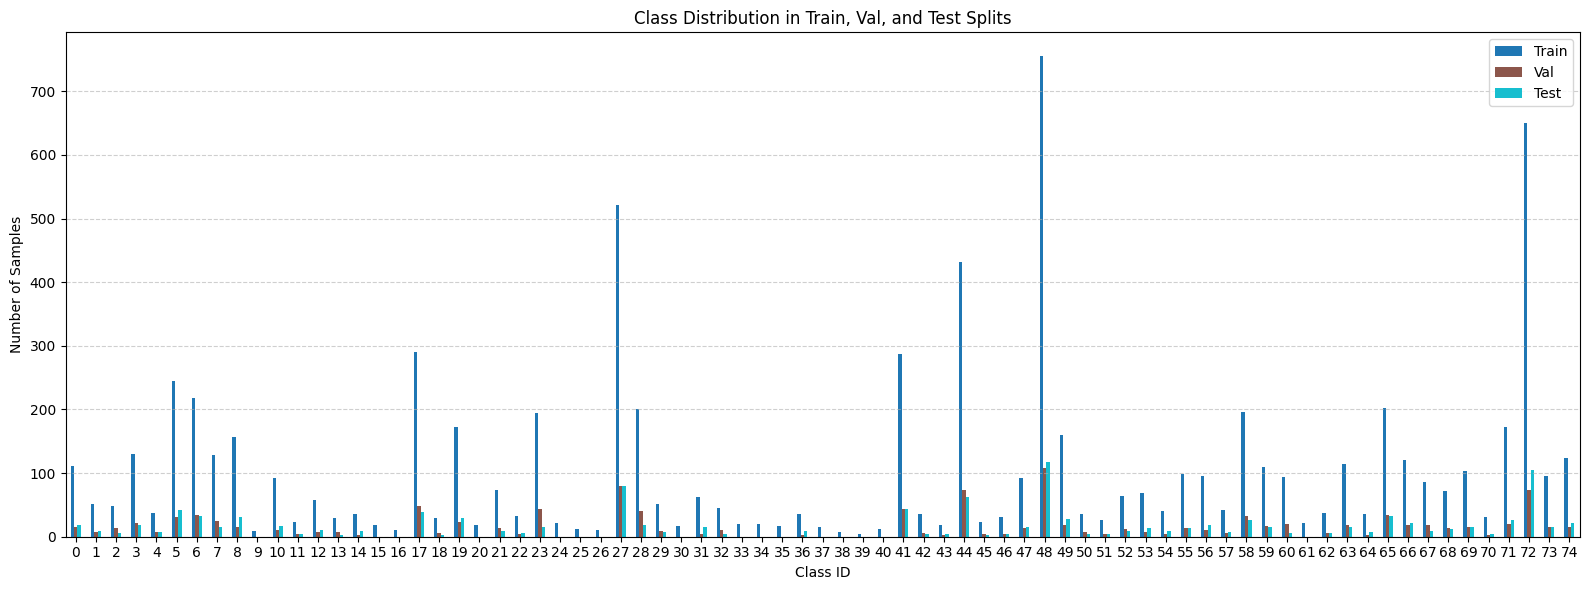

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Define label folder paths
label_dirs = {
    'Train': './final_dataset/train/labels',
    'Val': './final_dataset/val/labels',
    'Test': './final_dataset/test/labels'
}

# Count class occurrences for each split
split_counts = {}
for split_name, label_path in label_dirs.items():
    class_counter = Counter()
    for file in os.listdir(label_path):
        if file.endswith('.txt'):
            with open(os.path.join(label_path, file), 'r') as f:
                for line in f:
                    if line.strip():
                        try:
                            class_id = int(line.strip().split()[0])
                            class_counter[class_id] += 1
                        except ValueError:
                            continue
    split_counts[split_name] = class_counter

# Convert to DataFrame
df_dist = pd.DataFrame(split_counts).fillna(0).astype(int)
df_dist.index.name = 'Class ID'
df_dist = df_dist.sort_index()

# Plotting
plt.figure(figsize=(16, 6))
df_dist.plot(kind='bar', figsize=(16, 6), colormap='tab10')
plt.title('Class Distribution in Train, Val, and Test Splits')
plt.xlabel('Class ID')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [7]:
import pandas as pd

# Load class names from your Excel file
df = pd.read_csv('/content/dataset/Main/label_frequencies.xlsx - Label Frequencies.csv')

# Drop "Total" column and row if present
df = df.drop(columns=['Total'], errors='ignore')
df = df[df['Label'].str.lower() != 'total']

# Generate the 'names' YAML section
print("names:")
for idx, name in enumerate(df['Label']):
    print(f"  {idx}: {name}")


names:
  0: APR-09
  1: APR-10
  2: APR-11
  3: APR-12
  4: APR-14
  5: DWS-01
  6: DWS-02
  7: DWS-03
  8: DWS-04
  9: DWS-09
  10: DWS-10
  11: DWS-11
  12: DWS-12
  13: DWS-13
  14: DWS-14
  15: DWS-15
  16: DWS-16
  17: DWS-17
  18: DWS-18
  19: DWS-19
  20: DWS-20
  21: DWS-21
  22: DWS-25
  23: DWS-26
  24: DWS-27
  25: DWS-28
  26: DWS-29
  27: DWS-32
  28: DWS-33
  29: DWS-35
  30: DWS-36
  31: DWS-40
  32: DWS-41
  33: DWS-42
  34: DWS-44
  35: DWS-46
  36: MNS-01
  37: MNS-02
  38: MNS-03
  39: MNS-04
  40: MNS-05
  41: MNS-06
  42: MNS-07
  43: MNS-09
  44: OSD-01
  45: OSD-02
  46: OSD-03
  47: OSD-04
  48: OSD-06
  49: OSD-07
  50: OSD-16
  51: OSD-17
  52: OSD-26
  53: PHS-01
  54: PHS-02
  55: PHS-03
  56: PHS-04
  57: PHS-09
  58: PHS-23
  59: PHS-24
  60: PRS-01
  61: PRS-02
  62: RSS-02
  63: SLS-100
  64: SLS-15
  65: SLS-40
  66: SLS-50
  67: SLS-60
  68: SLS-70
  69: SLS-80
  70: TLS-C
  71: TLS-E
  72: TLS-G
  73: TLS-R
  74: TLS-Y


In [8]:
!pip install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu113
!pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Unin

In [9]:
import torch
import torch.nn as nn
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [13]:
import torch
import torch.nn as nn
from ultralytics import YOLO

# Load the pre-trained YOLOv8 model
model = YOLO('yolo11n.pt')  # You can choose other variants like yolov8s.pt, yolov8m.pt, etc.

100%|██████████| 5.35M/5.35M [00:00<00:00, 356MB/s]


In [15]:
from ultralytics import YOLO

# Load the YOLOv12n model (pretrained)
model = YOLO('yolo11n.pt')

# Train the model
model.train(
    data='/content/final_dataset/data.yaml',  # 👈 path to your data.yaml
    epochs=100,                     # number of epochs
    imgsz=640,                      # input image size
    batch=64,                       # experiment name
    verbose=True                   # show training logs
)

Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/final_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pre

100%|██████████| 755k/755k [00:00<00:00, 94.1MB/s]

Overriding model.yaml nc=80 with nc=75

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytic

YOLO11n summary: 181 layers, 2,616,950 parameters, 2,616,934 gradients, 6.6 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3047.2±2113.8 MB/s, size: 650.3 KB)


train: Scanning /content/final_dataset/train/labels... 6143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6143/6143 [00:03<00:00, 1538.59it/s]


train: New cache created: /content/final_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2739.4±1757.3 MB/s, size: 586.1 KB)


val: Scanning /content/final_dataset/val/labels... 920 images, 0 backgrounds, 0 corrupt: 100%|██████████| 920/920 [00:00<00:00, 1336.03it/s]

val: New cache created: /content/final_dataset/val/labels.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000127, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      9.38G      1.353       6.63     0.9961        142        640: 100%|██████████| 96/96 [00:48<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]

                   all        920       1155     0.0273     0.0685     0.0281     0.0216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      9.77G      1.312      5.492     0.9474        129        640: 100%|██████████| 96/96 [00:44<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]

                   all        920       1155       0.61      0.108     0.0648     0.0485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      9.79G      1.248      4.447     0.9379        149        640: 100%|██████████| 96/96 [00:44<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.08it/s]


                   all        920       1155      0.435      0.188      0.126     0.0981

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       9.8G       1.16      3.694     0.9198        152        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


                   all        920       1155      0.419      0.231       0.17      0.134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      9.82G      1.124      3.221     0.9115        133        640: 100%|██████████| 96/96 [00:44<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.16it/s]

                   all        920       1155      0.424      0.261      0.231      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      9.83G      1.075       2.89     0.9017        138        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]

                   all        920       1155      0.399      0.327      0.275       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      9.85G      1.064      2.644     0.8976        137        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]

                   all        920       1155      0.508      0.328      0.305      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      9.86G      1.037      2.415     0.8947        136        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


                   all        920       1155      0.475      0.392      0.357      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      9.88G      1.024      2.275     0.8935        164        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


                   all        920       1155      0.574       0.37      0.371      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      9.89G      1.006      2.123     0.8912        125        640: 100%|██████████| 96/96 [00:44<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.08it/s]


                   all        920       1155      0.511      0.438      0.397      0.324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      9.91G      1.002      2.018     0.8887        136        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.09it/s]


                   all        920       1155      0.532      0.444      0.411      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      9.92G     0.9719       1.87     0.8852        128        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.06it/s]


                   all        920       1155      0.594      0.452      0.445      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      9.94G     0.9727      1.801     0.8796        168        640: 100%|██████████| 96/96 [00:44<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.07it/s]

                   all        920       1155      0.635      0.431      0.456      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      9.95G     0.9659      1.693     0.8838        134        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.08it/s]


                   all        920       1155      0.695      0.416      0.465      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      9.97G     0.9465      1.601     0.8817        145        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]

                   all        920       1155      0.589      0.485      0.483      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      9.98G     0.9402       1.54     0.8786        147        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


                   all        920       1155      0.563      0.481      0.494       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100        10G     0.9513      1.513     0.8786        148        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.08it/s]


                   all        920       1155      0.591      0.495      0.502       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100        10G     0.9315      1.442       0.88        155        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


                   all        920       1155      0.667      0.485      0.503      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100        10G     0.9307      1.402     0.8773        115        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]

                   all        920       1155      0.612       0.51      0.522       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100        10G     0.9276      1.374     0.8736        155        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]

                   all        920       1155      0.685      0.501      0.541      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      10.1G     0.9029      1.276     0.8698        140        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


                   all        920       1155      0.712      0.481      0.531      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      10.1G     0.8959      1.251     0.8674        133        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.03it/s]


                   all        920       1155      0.765      0.482      0.553      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      10.1G     0.8994      1.217     0.8671        147        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.07it/s]


                   all        920       1155      0.767      0.498       0.57      0.467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      10.1G     0.8928      1.178     0.8652        152        640: 100%|██████████| 96/96 [00:44<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]

                   all        920       1155      0.722      0.532      0.573      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      10.1G     0.8814      1.141      0.868        131        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]

                   all        920       1155      0.703      0.543      0.579      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      10.1G     0.8829      1.126     0.8647        125        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.08it/s]


                   all        920       1155      0.695      0.537      0.591       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      10.1G     0.8863        1.1      0.869        150        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.09it/s]

                   all        920       1155       0.77      0.532      0.611      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      10.2G     0.8774      1.067     0.8671        132        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


                   all        920       1155      0.647       0.57      0.605      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      10.2G       0.87      1.049      0.863        145        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


                   all        920       1155      0.775      0.526       0.62      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      10.2G     0.8602      1.016     0.8617        139        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


                   all        920       1155      0.722      0.574      0.634       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      10.2G     0.8664      1.006     0.8645        152        640: 100%|██████████| 96/96 [00:44<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.09it/s]


                   all        920       1155      0.694       0.57      0.618      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      10.2G     0.8659     0.9947     0.8609        130        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.06it/s]

                   all        920       1155       0.79      0.564      0.658      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      10.2G     0.8713     0.9946     0.8613        164        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.07it/s]

                   all        920       1155      0.736       0.58      0.636      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      10.3G     0.8554     0.9524     0.8606        112        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.04it/s]


                   all        920       1155      0.804      0.536      0.644      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      10.3G     0.8333     0.9197     0.8555        123        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.09it/s]

                   all        920       1155      0.823      0.563      0.671      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      10.3G     0.8367     0.9084     0.8554        159        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.09it/s]

                   all        920       1155      0.779      0.583      0.649      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      10.3G     0.8394     0.9111     0.8555        136        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]

                   all        920       1155      0.823      0.592      0.675      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      10.3G      0.843     0.8962     0.8589        151        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]

                   all        920       1155      0.725      0.626      0.687      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      10.3G      0.854     0.9073     0.8619        115        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


                   all        920       1155      0.795      0.587      0.672      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      10.3G     0.8295     0.8595     0.8568        142        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.09it/s]


                   all        920       1155      0.844      0.591      0.685      0.544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      10.4G     0.8225     0.8635     0.8539        125        640: 100%|██████████| 96/96 [00:44<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]

                   all        920       1155      0.787      0.618      0.689      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      10.4G     0.8497     0.8623     0.8588        114        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]

                   all        920       1155       0.79      0.612      0.703      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      10.4G     0.8256     0.8437     0.8549        129        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.03it/s]

                   all        920       1155       0.85      0.595      0.709      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      10.4G     0.8155     0.8343     0.8527        123        640: 100%|██████████| 96/96 [00:44<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.07it/s]

                   all        920       1155      0.796       0.63      0.706      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      10.4G     0.8171     0.8317     0.8505        142        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.09it/s]


                   all        920       1155      0.738      0.642      0.707      0.567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      10.4G     0.8165     0.8121     0.8539        147        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]

                   all        920       1155      0.734      0.631      0.693      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      10.4G     0.8185     0.8095     0.8506        138        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.09it/s]


                   all        920       1155      0.794      0.629      0.704      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      10.5G     0.8133     0.7988     0.8529        183        640: 100%|██████████| 96/96 [00:44<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.08it/s]


                   all        920       1155      0.804      0.635      0.724      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      10.5G     0.8139     0.7944     0.8493        153        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]

                   all        920       1155      0.737      0.652      0.712      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      10.5G     0.8004     0.7786     0.8494        142        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]

                   all        920       1155       0.74      0.657      0.714      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      10.5G     0.7872     0.7614     0.8472        145        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]

                   all        920       1155      0.742      0.693      0.738      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      10.5G     0.8039     0.7657       0.85        134        640: 100%|██████████| 96/96 [00:44<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.03it/s]


                   all        920       1155      0.811      0.662      0.732      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      10.5G      0.808     0.7639     0.8511        143        640: 100%|██████████| 96/96 [00:44<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


                   all        920       1155       0.83      0.632       0.73      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      10.6G     0.7919     0.7551     0.8454        133        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.08it/s]


                   all        920       1155      0.707      0.678      0.733      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      10.6G     0.7912      0.745     0.8476        135        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.06it/s]

                   all        920       1155      0.843       0.63      0.727      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      10.6G     0.7951     0.7377      0.846        121        640: 100%|██████████| 96/96 [00:44<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.09it/s]


                   all        920       1155      0.759      0.685      0.738      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      10.6G     0.7799     0.7276     0.8434        162        640: 100%|██████████| 96/96 [00:44<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.09it/s]


                   all        920       1155      0.775      0.671      0.743       0.59

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      10.6G     0.7989     0.7376     0.8482        139        640: 100%|██████████| 96/96 [00:44<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


                   all        920       1155      0.747      0.679      0.742      0.591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      10.6G     0.7976     0.7235     0.8479        128        640: 100%|██████████| 96/96 [00:44<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


                   all        920       1155       0.82      0.654      0.748      0.595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      10.6G     0.7829     0.7138     0.8454        133        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.06it/s]


                   all        920       1155      0.775      0.673      0.744      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      10.7G      0.769     0.7045     0.8431        175        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.07it/s]

                   all        920       1155      0.791       0.67      0.745      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      10.7G     0.7798     0.7106     0.8457        158        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


                   all        920       1155      0.762      0.679      0.745      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      10.7G      0.785     0.7118     0.8435        132        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.00it/s]

                   all        920       1155      0.755      0.698      0.752      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      10.7G     0.7764     0.7024     0.8433        133        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.05it/s]


                   all        920       1155      0.779      0.675      0.747      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      10.7G     0.7748     0.6974     0.8444        145        640: 100%|██████████| 96/96 [00:44<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


                   all        920       1155       0.74      0.722      0.759       0.61

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      10.7G     0.7753     0.6973     0.8429        144        640: 100%|██████████| 96/96 [00:44<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.08it/s]


                   all        920       1155      0.828      0.673      0.746        0.6

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      10.7G     0.7691     0.6851       0.84        145        640: 100%|██████████| 96/96 [00:44<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]

                   all        920       1155       0.76       0.71      0.754      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      10.8G     0.7752     0.6947     0.8406        118        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.06it/s]


                   all        920       1155      0.832      0.695       0.76      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      10.8G     0.7713     0.6896      0.842        146        640: 100%|██████████| 96/96 [00:44<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.06it/s]


                   all        920       1155      0.809      0.698      0.762      0.609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      10.8G     0.7694      0.682     0.8405        140        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.08it/s]


                   all        920       1155      0.825      0.678      0.748      0.601

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      10.8G     0.7519     0.6584     0.8393        159        640: 100%|██████████| 96/96 [00:44<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.08it/s]


                   all        920       1155      0.839      0.688      0.756      0.602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      10.8G     0.7564     0.6651     0.8386        153        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]

                   all        920       1155      0.836      0.696      0.762      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      10.8G     0.7518     0.6592     0.8372        113        640: 100%|██████████| 96/96 [00:44<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.838      0.686      0.759      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      10.8G     0.7467     0.6464     0.8396        144        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.08it/s]


                   all        920       1155      0.791      0.715       0.76      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      10.9G     0.7693     0.6785     0.8393        150        640: 100%|██████████| 96/96 [00:44<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]

                   all        920       1155      0.815      0.708      0.769      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      10.9G     0.7555     0.6607      0.841        139        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]

                   all        920       1155      0.813      0.703      0.766      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      10.9G     0.7546     0.6582     0.8376        140        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]

                   all        920       1155      0.827      0.716      0.772      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      10.9G      0.743     0.6413      0.834        118        640: 100%|██████████| 96/96 [00:44<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]

                   all        920       1155      0.819      0.719      0.777      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      10.9G     0.7518     0.6529       0.84        121        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.09it/s]

                   all        920       1155      0.841      0.706      0.776      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      10.9G     0.7471     0.6455     0.8388        134        640: 100%|██████████| 96/96 [00:44<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.08it/s]

                   all        920       1155      0.855      0.708      0.776      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100        11G     0.7448     0.6437     0.8365        150        640: 100%|██████████| 96/96 [00:44<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.06it/s]

                   all        920       1155      0.837      0.722      0.781      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100        11G     0.7362     0.6229     0.8345        152        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.834      0.719      0.778      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100        11G     0.7447     0.6385     0.8342        148        640: 100%|██████████| 96/96 [00:44<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.06it/s]

                   all        920       1155      0.836      0.708      0.776       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100        11G     0.7341      0.627     0.8357        141        640: 100%|██████████| 96/96 [00:44<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.04it/s]

                   all        920       1155      0.832      0.705      0.774      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100        11G     0.7435     0.6309     0.8329        151        640: 100%|██████████| 96/96 [00:44<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]

                   all        920       1155      0.846      0.709      0.776      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100        11G      0.724     0.6124     0.8339        139        640: 100%|██████████| 96/96 [00:44<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.08it/s]


                   all        920       1155      0.827      0.719      0.777      0.622

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100        11G      0.733     0.6279     0.8345        133        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]

                   all        920       1155       0.84      0.706       0.78      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      11.1G      0.726     0.6217     0.8346        120        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]

                   all        920       1155       0.85      0.709      0.783      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      11.1G     0.7248     0.6159     0.8335        151        640: 100%|██████████| 96/96 [00:44<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


                   all        920       1155      0.803      0.728      0.784      0.626

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      11.1G     0.7366     0.6216     0.8353        135        640: 100%|██████████| 96/96 [00:44<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]

                   all        920       1155      0.808      0.736      0.784      0.625


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      9.62G     0.7488     0.6518      0.845         86        640: 100%|██████████| 96/96 [00:47<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]

                   all        920       1155      0.791      0.722      0.773      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100        10G     0.7095     0.5851      0.838         78        640: 100%|██████████| 96/96 [00:44<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]

                   all        920       1155       0.79      0.707      0.766      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100        10G     0.7008     0.5749     0.8337         81        640: 100%|██████████| 96/96 [00:44<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]

                   all        920       1155      0.784      0.703      0.767      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100        10G     0.6989     0.5697     0.8317         70        640: 100%|██████████| 96/96 [00:44<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]

                   all        920       1155      0.805       0.69      0.766       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100        10G     0.6937     0.5559     0.8334         69        640: 100%|██████████| 96/96 [00:44<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


                   all        920       1155      0.786      0.699      0.766      0.611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100        10G     0.6894     0.5561     0.8324         89        640: 100%|██████████| 96/96 [00:44<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]

                   all        920       1155      0.815      0.687      0.773      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100        10G     0.6937     0.5601     0.8312         82        640: 100%|██████████| 96/96 [00:44<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]

                   all        920       1155      0.804      0.693      0.772      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100        10G     0.6967     0.5664     0.8285         70        640: 100%|██████████| 96/96 [00:44<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]

                   all        920       1155      0.829      0.682      0.774      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100        10G     0.6917     0.5587     0.8331         69        640: 100%|██████████| 96/96 [00:44<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.828      0.682      0.772      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100        10G     0.6815     0.5492      0.829         78        640: 100%|██████████| 96/96 [00:44<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.08it/s]

                   all        920       1155      0.827      0.685      0.773      0.613



100 epochs completed in 1.357 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 5.5MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLO11n summary (fused): 100 layers, 2,609,163 parameters, 0 gradients, 6.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


                   all        920       1155      0.852      0.709      0.782      0.627
                APR-09         15         15      0.803      0.533      0.767      0.533
                APR-10          7          7      0.868      0.945      0.978      0.816
                APR-11         13         13      0.909      0.769      0.964      0.725
                APR-12         21         21      0.841      0.757      0.807       0.61
                APR-14          8          8      0.947      0.875      0.879      0.623
                DWS-01         31         31      0.955      0.968      0.993      0.922
                DWS-02         34         34          1       0.97      0.983      0.892
                DWS-03         24         24      0.964      0.917      0.982      0.902
                DWS-04         16         16      0.898      0.938      0.957        0.9
                DWS-10         11         11      0.924      0.909      0.967      0.819
                DWS-1

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 17, 18, 19, 21, 22, 23, 27, 28, 29, 31, 32, 36, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f3f8140fad0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031

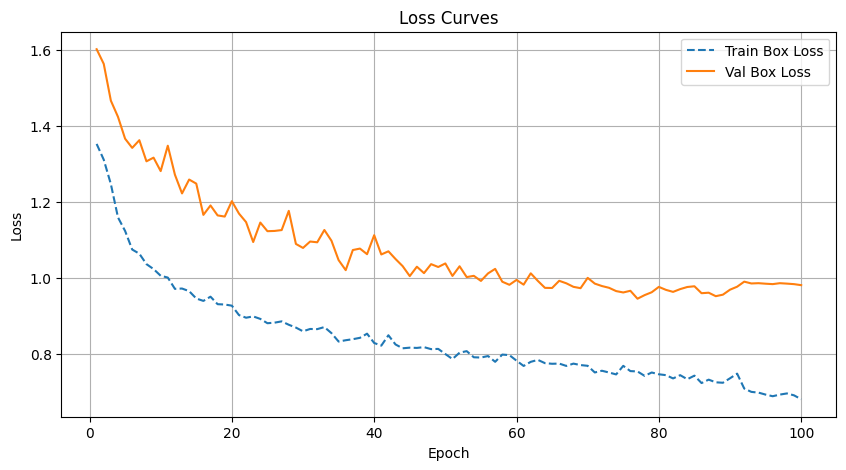

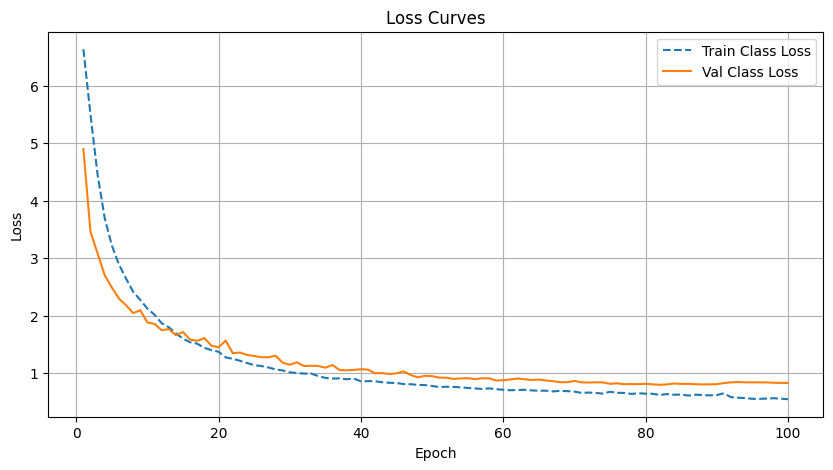

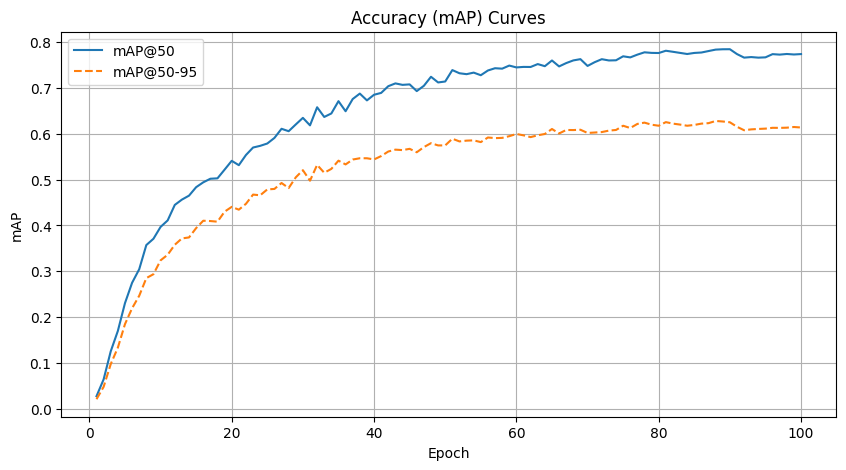

In [16]:
# Load the CSV file
results_path = "/content/runs/detect/train2/results.csv"  # Update path if needed
df = pd.read_csv(results_path)

# Remove extra spaces from column names
df.columns = df.columns.str.strip()

# Now, plot the curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', linestyle='dashed')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid()
plt.show()

print("     ")
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train/cls_loss'], label='Train Class Loss', linestyle='dashed')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid()
plt.show()

print("     ")
# Plot mAP Accuracy Curves
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@50')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@50-95', linestyle='dashed')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('Accuracy (mAP) Curves')
plt.legend()
plt.grid()
plt.show()

In [17]:
results = model.val()
print(results)

Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLO11n summary (fused): 100 layers, 2,609,163 parameters, 0 gradients, 6.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3869.9±2158.7 MB/s, size: 714.2 KB)


val: Scanning /content/final_dataset/val/labels.cache... 920 images, 0 backgrounds, 0 corrupt: 100%|██████████| 920/920 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


                   all        920       1155      0.848       0.71      0.782      0.629
                APR-09         15         15      0.803      0.533      0.764      0.524
                APR-10          7          7      0.868      0.946      0.978      0.816
                APR-11         13         13      0.834      0.772      0.964      0.725
                APR-12         21         21      0.842      0.764      0.817      0.611
                APR-14          8          8      0.936      0.875      0.879       0.63
                DWS-01         31         31      0.955      0.968      0.993      0.918
                DWS-02         34         34          1       0.97      0.983      0.891
                DWS-03         24         24      0.963      0.917      0.982      0.901
                DWS-04         16         16      0.898      0.938      0.957      0.899
                DWS-10         11         11      0.923      0.909      0.967      0.817
                DWS-1

In [19]:
from thop import profile
from ultralytics import YOLO
import torch

# ✅ Load model properly
model = YOLO('/content/runs/detect/train2/weights/best.pt')
torch_model = model.model  # Raw nn.Module

# ✅ Create dummy input
device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_tensor = torch.randn(1, 3, 640, 640).to(device)

# ✅ Move model to same device
torch_model = torch_model.to(device)

# ✅ Profile
macs, params = profile(torch_model, inputs=(input_tensor,), verbose=False)

# ✅ Print results
print(f"Params: {params / 1e6:.2f} Million")
print(f"MACs: {macs / 1e9:.2f} GMACs")
print(f"FLOPs: {2 * macs / 1e9:.2f} GFLOPs (approx)")

Params: 2.62 Million
MACs: 3.29 GMACs
FLOPs: 6.58 GFLOPs (approx)


In [21]:
from ultralytics import YOLO

# Load your trained YOLOv8n model
model = YOLO('/content/runs/detect/train2/weights/best.pt')  # change path if needed

# Evaluate on validation set
metrics = model.val()

Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLO11n summary (fused): 100 layers, 2,609,163 parameters, 0 gradients, 6.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5277.3±878.5 MB/s, size: 641.5 KB)


val: Scanning /content/final_dataset/val/labels.cache... 920 images, 0 backgrounds, 0 corrupt: 100%|██████████| 920/920 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:05<00:00, 10.78it/s]


                   all        920       1155      0.849      0.709      0.782      0.629
                APR-09         15         15      0.804      0.533      0.764      0.524
                APR-10          7          7      0.868      0.944      0.978      0.816
                APR-11         13         13      0.834      0.772      0.964      0.725
                APR-12         21         21      0.842      0.762      0.806       0.61
                APR-14          8          8      0.943      0.875      0.879       0.63
                DWS-01         31         31      0.955      0.968      0.993      0.918
                DWS-02         34         34          1       0.97      0.983      0.891
                DWS-03         24         24      0.964      0.917      0.982      0.901
                DWS-04         16         16      0.898      0.938      0.957      0.899
                DWS-10         11         11      0.924      0.909      0.967      0.817
                DWS-1

In [22]:
# Extract metrics from `metrics.box`
precision = metrics.box.p.mean()       # mean precision
recall = metrics.box.r.mean()          # mean recall
map50 = metrics.box.ap50.mean()        # mAP@0.5
map5095 = metrics.box.ap.mean()        # mAP@0.5:0.95

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)

# Print summary
print("\n✅ 📊 Overall Evaluation Summary:")
print(f"{'Metric':<15} | {'Value':>8}")
print(f"{'-'*26}")
print(f"{'mAP@50':<15} | {map50:.3f}")
print(f"{'mAP@50-95':<15} | {map5095:.3f}")
print(f"{'Precision':<15} | {precision:.3f}")
print(f"{'Recall':<15} | {recall:.3f}")
print(f"{'F1-Score':<15} | {f1_score:.3f}")


✅ 📊 Overall Evaluation Summary:
Metric          |    Value
--------------------------
mAP@50          | 0.782
mAP@50-95       | 0.629
Precision       | 0.849
Recall          | 0.709
F1-Score        | 0.773
